<a href="https://colab.research.google.com/github/chl-eo/CCDEPLRL_EXERCISES/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7

Text Generation using LSTM

In [494]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [495]:
tokenizer = Tokenizer()

!wget --no-check-certificate \
    https://raw.githubusercontent.com/cibernox/storyteller/refs/heads/master/snow-white.txt \
    -O /tmp/snowwhite.txt

data = open('/tmp/snowwhite.txt').read()

--2025-05-27 09:33:07--  https://raw.githubusercontent.com/cibernox/storyteller/refs/heads/master/snow-white.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520 (1.5K) [text/plain]
Saving to: ‘/tmp/snowwhite.txt’

/tmp/snowwhite.txt  100%[===================>]   1.48K  --.-KB/s    in 0s      

2025-05-27 09:33:07 (23.7 MB/s) - ‘/tmp/snowwhite.txt’ saved [1520/1520]



In [496]:
corpus = [line.strip().lower() for line in data.split("\n") if line.strip()]
corpus = [line for line in corpus if len(line.split()) > 3]

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

## Create the LSTM model

1. Build an LSTM

In [497]:
def sample_with_temperature(preds, temperature=1.0, top_k=10):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    top_preds_idx = preds.argsort()[-top_k:][::-1]
    top_preds = preds[top_preds_idx]
    top_preds = top_preds / np.sum(top_preds)
    return np.random.choice(top_preds_idx, p=top_preds)

In [498]:
model = Sequential()
model.add(Embedding(total_words, 512, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.6))  # Increased dropout rate
model.add(LSTM(128))
# Increase the regularization strength in the dense layer
model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-2))) # Increased regularization strength
model.add(Dense(total_words, activation='softmax'))

# Keep the optimizer and compilation as is for now
optimizer = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_55 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_55                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_100 (LSTM)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [499]:
early_stop = EarlyStopping(monitor='loss', patience=25, restore_best_weights=True)
history = model.fit(predictors, label, epochs=100, verbose=1, callbacks=[early_stop])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.0387 - loss: 5.7380
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0675 - loss: 5.0483
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0532 - loss: 4.6836
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0839 - loss: 4.3854
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0828 - loss: 4.0483
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0750 - loss: 3.9862
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1512 - loss: 3.7029
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1606 - loss: 3.6665
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1973 - loss: 3.4556
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3124 - loss: 3.0084
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3627 - loss: 2.8522
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3295 - lo

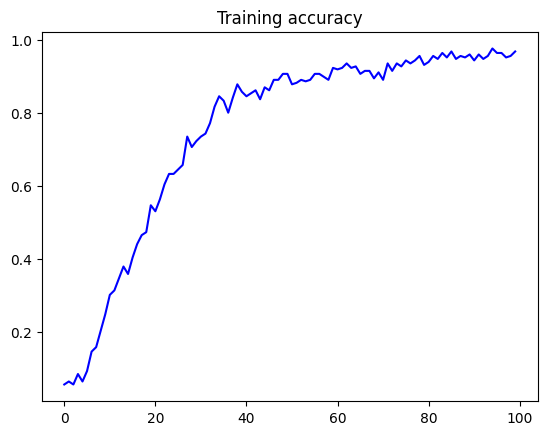

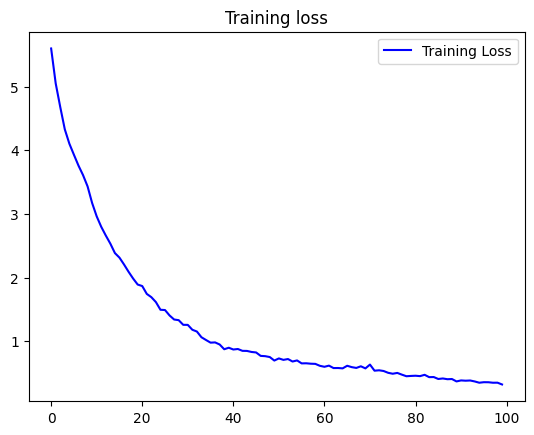

In [500]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## B. Generate texts


2. "Snow White lived in the forest with..."

In [528]:
reverse_word_index = dict((index, word) for word, index in tokenizer.word_index.items())
seed_text = "Snow White lived in the forest with"
next_words = 10
temperature = 4
top_k = 15

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probabilities = model.predict(token_list, verbose=0)[0]

    predicted_index = sample_with_temperature(predicted_probabilities, temperature=temperature, top_k=top_k)

    output_word = reverse_word_index.get(predicted_index, '')
    seed_text += " " + output_word

# 10. Clean and print
import textwrap

final_output = seed_text.replace(" .", ".").replace(" ,", ",")
final_output = final_output.replace(" !", "!").replace(" ?", "?")
final_output = final_output.replace(" :", ":").replace(" ;", ";")

final_output = final_output[0].upper() + final_output[1:]
print("\n".join(textwrap.wrap(final_output, width=80)))

Snow White lived in the forest with furious and the far snow white on they was
rival


3. "The queen looked into the mirror and said..."

In [534]:
reverse_word_index = dict((index, word) for word, index in tokenizer.word_index.items())
seed_text = "The queen looked into the mirror and said"
next_words = 10
temperature = 6
top_k = 30

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probabilities = model.predict(token_list, verbose=0)[0]

    predicted_index = sample_with_temperature(predicted_probabilities, temperature=temperature, top_k=top_k)

    output_word = reverse_word_index.get(predicted_index, '')
    seed_text += " " + output_word

# 10. Clean and print
import textwrap

final_output = seed_text.replace(" .", ".").replace(" ,", ",")
final_output = final_output.replace(" !", "!").replace(" ?", "?")
final_output = final_output.replace(" :", ":").replace(" ;", ";")

final_output = final_output[0].upper() + final_output[1:]
print("\n".join(textwrap.wrap(final_output, width=80)))

The queen looked into the mirror and said take up fell all your grew mirror last
the strange


4. "One day, Snow White found a small cottage and..."

In [535]:
reverse_word_index = dict((index, word) for word, index in tokenizer.word_index.items())
seed_text = "One day, Snow White found a small cottage and"
next_words = 10
temperature = 0.7
top_k = 15

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probabilities = model.predict(token_list, verbose=0)[0]

    predicted_index = sample_with_temperature(predicted_probabilities, temperature=temperature, top_k=top_k)

    output_word = reverse_word_index.get(predicted_index, '')
    seed_text += " " + output_word

# 10. Clean and print
import textwrap

final_output = seed_text.replace(" .", ".").replace(" ,", ",")
final_output = final_output.replace(" !", "!").replace(" ?", "?")
final_output = final_output.replace(" :", ":").replace(" ;", ";")

final_output = final_output[0].upper() + final_output[1:]
print("\n".join(textwrap.wrap(final_output, width=80)))

One day, Snow White found a small cottage and she heard it say to the fatal spot
the magic


In [504]:
reverse_word_index = dict((index, word) for word, index in tokenizer.word_index.items())
seed_text = "Snow white is"
next_words = 5
temperature = 1
top_k = 15

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probabilities = model.predict(token_list, verbose=0)[0]

    predicted_index = sample_with_temperature(predicted_probabilities, temperature=temperature, top_k=top_k)

    output_word = reverse_word_index.get(predicted_index, '')
    seed_text += " " + output_word

# 10. Clean and print
import textwrap

final_output = seed_text.replace(" .", ".").replace(" ,", ",")
final_output = final_output.replace(" !", "!").replace(" ?", "?")
final_output = final_output.replace(" :", ":").replace(" ;", ";")

final_output = final_output[0].upper() + final_output[1:]
print("\n".join(textwrap.wrap(final_output, width=80)))

Snow white is the loveliest in the land
